In [1]:
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
# import electrode
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped, utils)
from scipy.signal import argrelextrema
import math
from scipy.optimize import minimize

In [28]:
# n electrodes per row (10 default)
# number of rows (2 default)
# width of electrode
# height of electrode
# spacing between electrodes
# tuple of coordinates to start each row
    # top row x-coordinate (bottom left point)
    # top row y-coordinate (bottom left point)

#...
# bottom row x-coordinate (bottom left point)
# bottom row y-coordinate (bottom left point)
def trap(spacing, dc_width, dc_height, dc_start_pos,
         rf_width, rf_height, rf_start_pos,
         dc_mid_width, dc_mid_height, dc_mid_start_pos,
         n=9, r=2):
    #define effective size, without dielectric gaps
    w_eff = dc_width + spacing
    h_eff = dc_height + spacing

    electrodes = []
    #start with top row
    row = 0
    for sp in dc_start_pos:
        xp_start = sp[0] - spacing/2
        yp = sp[1] - spacing/2
        for electrode in range(n):
            # e.g. electrode 2 would be leftmost in top row
            # e.g. electrode 12 would be leftmost in bottom row
            electrode_id = str(row * (n+1) + electrode + 2)
            x_shift = electrode * w_eff
            xp = xp_start + x_shift
            print(xp)
            electrodes.append(
                (electrode_id, [[
                    (xp, yp),
                    (xp + w_eff, yp),
                    (xp + w_eff, yp + h_eff),
                    (xp, yp + h_eff)
                ]])
            )
        row += 1
    # add rf electrodes
    rf_w_eff = rf_width + spacing
    rf_h_eff = rf_height + spacing
    for i in range (2):
        xp = rf_start_pos[i][0] - spacing/2
        yp = rf_start_pos[i][1] - spacing/2
        # rf_e_id = str('r'+i+1) #use this for unique rf electrode id
        rf_e_id = str('r')
        electrodes.append(
            (rf_e_id, [[
                (xp, yp),
                (xp + rf_w_eff, yp),
                (xp + rf_w_eff, yp + rf_h_eff),
                (xp, yp + rf_h_eff)
            ]])
        )
        
    dc_mid_w_eff = dc_mid_width + spacing
    dc_mid_h_eff = dc_mid_height + spacing
    for i in range (2):
        xp = dc_mid_start_pos[i][0] - spacing/2
        yp = dc_mid_start_pos[i][1] - spacing/2
        dc_mid_id = str(i+1)
        electrodes.append(
            (dc_mid_id, [[
                (xp, yp),
                (xp + dc_mid_w_eff, yp),
                (xp + dc_mid_w_eff, yp + dc_mid_h_eff),
                (xp, yp + dc_mid_h_eff)
            ]])
        )
    
    s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p))
                for n, p in electrodes])
    s['r'].rf = 1.
    return s

-562.5
-437.5
-312.5
-187.5
-62.5
62.5
187.5
312.5
437.5
-562.5
-437.5
-312.5
-187.5
-62.5
62.5
187.5
312.5
437.5


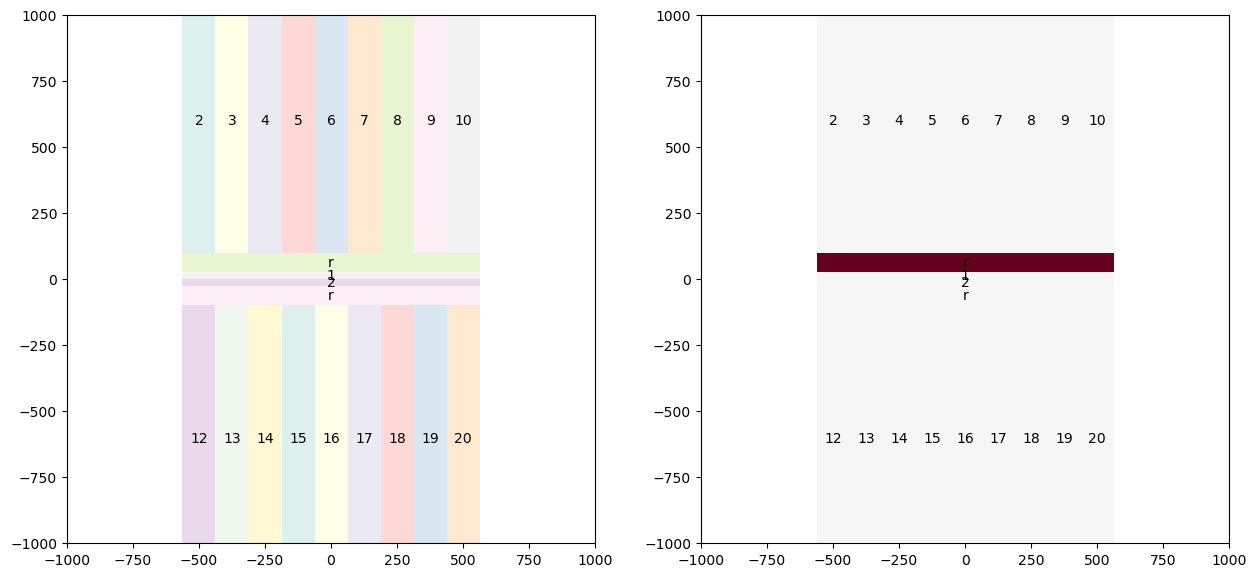

In [29]:
spacing = 5.
n = 9
dc_width = 120.
# dc_height = 1000.
dc_height = 1000.
dc_mid_height = 20.
dc_mid_width = n * dc_width + (n-1) * spacing
rf_height = 70.
rf_width = n * dc_width + (n-1) * spacing
dc_start_pos = [(-(4.5*dc_width + 4*spacing), (2.5*spacing + dc_mid_height + rf_height)),
               (-(4.5*dc_width + 4*spacing), -(2.5*spacing + dc_mid_height + rf_height + dc_height))]
rf_start_pos = [(-(4.5*dc_width + 4*spacing), (1.5*spacing + dc_mid_height)),
               (-(4.5*dc_width + 4*spacing), -(1.5*spacing + dc_mid_height + rf_height))]
dc_mid_start_pos = [(-(4.5*dc_width + 4*spacing), (.5*spacing)),
                   (-(4.5*dc_width + 4*spacing), -(.5*spacing +dc_mid_height))]

s = trap(spacing, dc_width, dc_height, dc_start_pos,
         rf_width, rf_height, rf_start_pos,
         dc_mid_width, dc_mid_height, dc_mid_start_pos,
         n, r=2)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
s.plot(ax[0])
s.plot_voltages(ax[1], u=s.rfs)

r= 1000
for axi in ax.flat:
    axi.set_aspect("equal")
    axi.set_xlim(-r, r)
    axi.set_ylim(-r, r)

In [35]:
l = 50e-6 # µm length scale
u = 20. # V rf peak voltage
m = 40*ct.atomic_mass # Ca ion mass
q = 1*ct.elementary_charge # ion charge
o = 2*np.pi*30e6 # rf frequency in rad/s
s["r"].rf = u*np.sqrt(q/m)/(2*l*o)

x0 = s.minimum((0, 0, 1.), axis=(1, 2))

for line in s.analyze_static(x0, axis=(1, 2), m=m, q=-q, l=l, o=o):
    print(line)

parameters:
 f=30 MHz, m=40 amu, q=-1 qe, l=50 µm, scale=nan V'/V_SI
corrdinates:
 analyze point: [ 0.         -7.45322227  1.25190591]
               ([   0.         -372.66111354   62.59529566] µm)
 minimum is at offset: [0. 0. 0.]
                      ([0. 0. 0.] µm)
potential:
 dc electrical: 0 eV
 rf pseudo: 0.00013 eV
 saddle not found
force:
 dc electrical: [0. 0. 0.] eV/l
               ([0. 0. 0.] eV/m)
 rf pseudo: [ 5.92746869e-25  1.01278979e-05 -3.24619218e-07] eV/l
           ([ 1.18549374e-20  2.02557959e-01 -6.49238435e-03] eV/m)
modes:


/opt/homebrew/anaconda3/envs/pqe7/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-macosx-10.9-x86_64.egg/electrode/system.py:840: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(q/m)/(2*l*o)
/opt/homebrew/anaconda3/envs/pqe7/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-macosx-10.9-x86_64.egg/electrode/system.py:879: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)


LinAlgError: Array must not contain infs or NaNs